<a href="https://colab.research.google.com/github/ddinesan/Manga/blob/master/Lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Running Quantum Algorithms on Hardware**

This is a worksheet prepared by Evan Peters for Lecture 5 of the reading course "Introduction to Quantum Computer Programming" (AMATH 900/ AMATH 495/ QIC 895) at the University of Waterloo.

Course Webpage: https://sites.google.com/view/quantum-computer-programming

Text followed in the course: [Quantum Computing, An Applied Approach](https://www.springer.com/gp/book/9783030239213) by Jack D. Hidary (2019)

In [ ]:
!pip install cirq qutip

# Running algorithms on hardware

This notebook will review some of the extra considerations required for running quantum circuits on hardware. From the lecture, there are four main considerations for preparing algorithms to run on hardware:
1. Native gatesets
2. Qubit decoherence
3. Gate fidelity
4. Connectivity

Alongside these concepts we will explore the following features of Cirq:
  - Optimizers and decompositions
  - Noise channels

## 1. Native gatesets

The physical implementation of a qubit puts strong limitations on the types of gates that can be applied efficiently. **The reason we care about hardware gatesets is that the added depth of a decomposition might make or break a given algorithm**

Lets look at a few examples of gate sets supported on the Google chip:

In [ ]:
from cirq.google import gate_sets # import the module containing gate sets
dir(gate_sets) # `dir` is an awesome function for inspecting the contents of modules

['CZ_POW_DESERIALIZER',
 'CZ_POW_SERIALIZER',
 'MEASUREMENT_DESERIALIZER',
 'MEASUREMENT_SERIALIZER',
 'SINGLE_QUBIT_DESERIALIZERS',
 'SINGLE_QUBIT_HALF_PI_DESERIALIZERS',
 'SINGLE_QUBIT_HALF_PI_SERIALIZERS',
 'SINGLE_QUBIT_SERIALIZERS',
 'SQRT_ISWAP_DESERIALIZERS',
 'SQRT_ISWAP_GATESET',
 'SQRT_ISWAP_SERIALIZERS',
 'SYC_DESERIALIZER',
 'SYC_GATESET',
 'SYC_SERIALIZER',
 'WAIT_GATE_DESERIALIZER',
 'WAIT_GATE_SERIALIZER',
 'XMON',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'document',
 'serializable_gate_set']

From inspecting the `gate_sets` module, we see mostly serializers. Serialization refers to the process of transforming an 'object' in a program into some flattened sequence of numbers or characters. In Cirq, serialization is used to convert a `Circuit` object into a form that can be easily transmitted and read by the microwave hardware near the fridge.

The other items we see are gatesets, which we can inspect using the functions below:


In [ ]:
print("\nXMON")
display(gate_sets.XMON.supported_gate_types())
print("\nSYCAMORE")
display(gate_sets.SYC_GATESET.supported_gate_types())



XMON


(cirq.ops.phased_x_gate.PhasedXPowGate,
 cirq.ops.common_gates.XPowGate,
 cirq.ops.common_gates.YPowGate,
 cirq.ops.common_gates.ZPowGate,
 cirq.ops.phased_x_z_gate.PhasedXZGate,
 cirq.ops.common_gates.CZPowGate,
 cirq.ops.measurement_gate.MeasurementGate)


SYCAMORE


(cirq.ops.fsim_gate.FSimGate,
 cirq.ops.phased_x_gate.PhasedXPowGate,
 cirq.ops.common_gates.XPowGate,
 cirq.ops.common_gates.YPowGate,
 cirq.ops.common_gates.ZPowGate,
 cirq.ops.phased_x_z_gate.PhasedXZGate,
 cirq.ops.measurement_gate.MeasurementGate,
 cirq.ops.wait_gate.WaitGate)

Theres a few uncommon gates in these lists. For example, the FSimGate is an obscure gate named after its utility in Fermionic simulations. The general gate is defined in the following diagrams (Google, 2019):

![](https://drive.google.com/uc?id=1ZAb16tcG1R3UD_I54_1gikn4KtTYlm8h)    

The Sycamore hardware (as discussed in the supremacy paper) is limited to implementing `FSim(90, 30)`, and so the gateset we saw above is actually much more limited than it seems at first glance. Of course, we can always view a gate's unitary form using cirq:


In [ ]:
import cirq
import numpy as np

sycamore_gate = cirq.FSimGate(np.pi/2, np.pi/6)
np.round(cirq.unitary(sycamore_gate), decimals=4) # round off the floating precision error
help(cirq.FSimGate)

Help on class FSimGate in module cirq.ops.fsim_gate:

class FSimGate(cirq.ops.gate_features.TwoQubitGate, cirq.ops.gate_features.InterchangeableQubitsGate)
 |  Fermionic simulation gate family.
 |  
 |  Contains all two qubit interactions that preserve excitations, up to
 |  single-qubit rotations and global phase.
 |  
 |  The unitary matrix of this gate is:
 |  
 |      [[1, 0, 0, 0],
 |       [0, a, b, 0],
 |       [0, b, a, 0],
 |       [0, 0, 0, c]]
 |  
 |  where:
 |  
 |      a = cos(theta)
 |      b = -i·sin(theta)
 |      c = exp(-i·phi)
 |  
 |  Note the difference in sign conventions between FSimGate and the
 |  ISWAP and CZPowGate:
 |  
 |      FSimGate(θ, φ) = ISWAP**(-2θ/π) CZPowGate(exponent=-φ/π)
 |  
 |  Method resolution order:
 |      FSimGate
 |      cirq.ops.gate_features.TwoQubitGate
 |      cirq.ops.raw_types.Gate
 |      cirq.ops.gate_features.InterchangeableQubitsGate
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__ = _value_equality_eq(se

### Gate decompositions

Given restrictions imposed by the hardware native gate set, we have to be able to decompose the gates that we want to use into the available ones, or else decide to use different gates entirely. This is not always a straightforward problem.

For example, suppose we want to apply a SWAP gate on the Google Sycamore hardware, restricting ourselves to the "Sycamore gate" described above. Our first attempt will be to convert the SWAP gate into Sycamore gates using a decomposition provided by Cirq.

In [ ]:
from cirq import optimizers # Contains many of the current decomposition strategies

# This function takes in a unitary-like object (cirq.SWAP) and decomposes it into
# something with only FSimGates for entanglement
decomposed = optimizers.decompose_two_qubit_interaction_into_four_fsim_gates_via_b(
      cirq.SWAP, fsim_gate=sycamore_gate)



┌                           ┐                        ┌                           ┐                        ┌                           ┐                        ┌                           ┐                        ┌                           ┐
0: ─────────────│-0.107+0.894j -0.418+0.119j│───fsim(0.5π, 0.167π)───│-0.097-0.739j  0.661+0.087j│───fsim(0.5π, 0.167π)───│-0.297-0.674j -0.088+0.671j│───fsim(0.5π, 0.167π)───│-0.097-0.739j  0.661+0.087j│───fsim(0.5π, 0.167π)───│ 0.523+0.611j  0.496-0.328j│───
                │ 0.418+0.119j -0.107-0.894j│   │                    │-0.661+0.087j -0.097+0.739j│   │                    │ 0.088+0.671j -0.297+0.674j│   │                    │-0.661+0.087j -0.097+0.739j│   │                    │-0.496-0.328j  0.523-0.611j│
                └                           ┘   │                    └                           ┘   │                    └                           ┘   │                    └                           ┘   │                    └                           ┘
                                                │                                                    │                                                    │                                                    │
                ┌                           ┐   │                    ┌                           ┐   │                    ┌                           ┐   │                    ┌                           ┐   │                    ┌                           ┐
1: ─────────────│ 0.156+0.978j  0.135+0.024j│───#2───────────────────│ 0.9  -0.118j  0.055-0.417j│───#2───────────────────│ 0.616-0.736j -0.278-0.037j│───#2───────────────────│ 0.9  -0.118j  0.055-0.417j│───#2───────────────────│ 0.483-0.816j -0.316-0.044j│───
                │-0.135+0.024j  0.156-0.978j│                        │-0.055-0.417j  0.9  +0.118j│                        │ 0.278-0.037j  0.616+0.736j│                        │-0.055-0.417j  0.9  +0.118j│                        │ 0.316-0.044j  0.483+0.816j│
                └                           ┘                        └                           ┘                        └                           ┘                        └                           ┘                        └                           ┘

global phase:   0.917π

Yikes! The optimizer is suggesting a depth-8 decomposition that uses arbitrary single-qubit gates (which must further be decomposed!). However if we loosen the restriction to allow for parametrization of the `FSimGate`, our job is easy!

---
*Quiz: code up a way to implement SWAP using arbitrarily parametrized FSimGate.*

*Hint: You'll need to get rid of some phases...*


In [ ]:
# Your code here

Answer:

In [ ]:
#@title
qubits = cirq.GridQubit.rect(1,2)
circuit = cirq.Circuit()
circuit += cirq.FSimGate(np.pi/2, np.pi).on(qubits[0], qubits[1])
circuit += cirq.S(qubits[0]) # Get rid of accumulated i's
circuit += cirq.S(qubits[1])
display(np.round(cirq.unitary(circuit), 2))

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

---
The availability of arbitrary two-qubit entangling gates makes a difference of depth-6 per SWAP gate. In general, hardware gate availability can have a massive influence on the types of gates/algorithms you choose to run. Even when a decomposition exists, it may not be wise to use it. Another example, this time restricting ourselves to use only sqrt(iSWAP) entangling gates:

In [ ]:
def hardware_native_zzpow(angle, q1, q2):
    """This circuit generator uses a parametrized entangling gate that
    decomposes into:
        exp(i*theta*Z0Z1)
    """
    theta = -2 * angle

    # Handle theta above np.pi
    theta = (theta % 2) * np.pi
    if 0 <= theta <= np.pi:
        sign = 1.
        theta_prime = theta
    elif np.pi < theta < 2 * np.pi:
        sign = -1.
        theta_prime = 2 * np.pi - theta

    # Calculate decomposition angles
    phi = np.arcsin(np.sqrt(2) * np.sin(theta_prime / 4))
    xi = np.arctan(np.tan(phi) / np.sqrt(2))
    rz = sign * 0.5 * theta_prime / np.pi
    xi = xi / np.pi
    pre_x = -sign * 0.5
    rx = -2 * phi / np.pi
    post_x = sign * 0.5

    yield cirq.ZPowGate(exponent=angle)(q1)
    yield cirq.ZPowGate(exponent=angle)(q2)

    yield cirq.ZPowGate(exponent=rz, global_shift=-0.5).on(q1)
    yield cirq.ZPowGate(exponent=rz, global_shift=-0.5).on(q2)
    yield cirq.XPowGate(exponent=xi, global_shift=-0.5).on(q1)
    yield cirq.X(q2)**pre_x
    yield cirq.ISWAP(q1, q2)**-0.5
    yield cirq.XPowGate(exponent=rx, global_shift=-0.5).on(q1)
    yield cirq.Z(q1)
    yield cirq.ISWAP(q1, q2)**-0.5
    yield cirq.Z(q1)
    yield cirq.XPowGate(exponent=xi, global_shift=-0.5).on(q1)
    yield cirq.X(q2)**post_x



Lets view this decomposition and confirm that it actually produces the ZZPowGate

In [ ]:
print("ZZPowGate:\n")
sim_circuit = cirq.Circuit(cirq.ZZPowGate(exponent=1.23).on(qubits[0], qubits[1]))
print(sim_circuit,"\n")
np.set_printoptions(precision=3)
print(cirq.unitary(sim_circuit))
print("\n Decomposed ZZPowGate using sqrt(iSWAP) hardware gate:\n")
hw_circuit = cirq.Circuit(hardware_native_zzpow(1.23, qubits[0], qubits[1]))
print(hw_circuit,"\n")
print(np.round(cirq.unitary(hw_circuit), 3))
print("\nAre these gates equal up to global phase?")
cirq.allclose_up_to_global_phase(cirq.unitary(hw_circuit), cirq.unitary(sim_circuit))

ZZPowGate:

(0, 0): ───ZZ────────────
           │
(0, 1): ───ZZ^(-10/13)─── 

[[ 1.  +0.j     0.  +0.j     0.  +0.j     0.  +0.j   ]
 [ 0.  -0.j    -0.75-0.661j  0.  -0.j     0.  -0.j   ]
 [ 0.  -0.j     0.  -0.j    -0.75-0.661j  0.  -0.j   ]
 [ 0.  +0.j     0.  +0.j     0.  +0.j     1.  +0.j   ]]

 Decomposed ZZPowGate using sqrt(iSWAP) hardware gate:

(0, 0): ───Z^(-10/13)───Rz(-0.23π)───Rx(0.123π)───iSwap────────Rx(-0.333π)───Z───iSwap────────Z────────Rx(0.123π)───
                                                  │                              │
(0, 1): ───Z^(-10/13)───Rz(-0.23π)───X^0.5────────iSwap^-0.5─────────────────────iSwap^-0.5───X^-0.5──────────────── 

[[ 0.935+0.353j  0.   +0.j     0.   -0.j    -0.   +0.j   ]
 [-0.   +0.j    -0.468-0.884j  0.   +0.j    -0.   +0.j   ]
 [-0.   -0.j     0.   +0.j    -0.468-0.884j -0.   +0.j   ]
 [ 0.   -0.j     0.   -0.j     0.   +0.j     0.935+0.353j]]

Are these gates equal up to global phase?


True

## 2. Qubit decoherence

Decoherence describes loss of information from a qubit due to coupling with some part of the environment outside the control of the quantum computer. One way to view decoherences is as a transformation that takes a state off of the surface of the Bloch sphere. **The reason we care about modelling noise is that we need to be able to interpret imperfect results that we retreive from the hardware**

Lets dive into an example using a bitflip noise model.


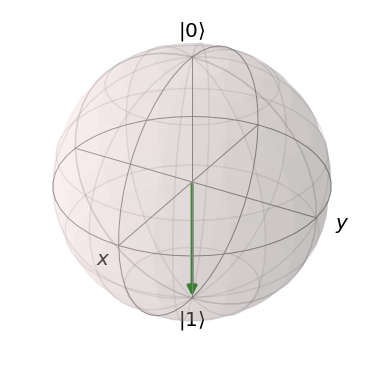

In [ ]:
# First, define the channel using a built-in noise class
bitflip_prob = 0.3
bitflip_channel = cirq.bit_flip(bitflip_prob)

# Next, prepare a state using a circuit like you normally would
circuit = cirq.Circuit(cirq.X(qubits[0])) # Prepares the |1> state
initial_state = cirq.Simulator().simulate(circuit).final_state

# Now we wish to plot our state on the Bloch sphere. To do this, we'll use
# another quantum library, 'qutip'
import qutip
b = qutip.Bloch()
# convert our state to a bloch vector
bloch_vector = cirq.bloch_vector_from_state_vector(initial_state, 0)
b.add_vectors(bloch_vector)
b.show()

(0, 0): ───X───BF(0.3)───

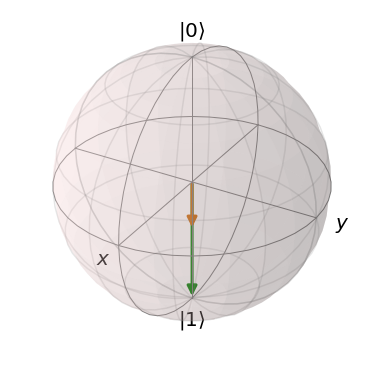

In [ ]:
# Now we'll plot what happens to our vector if we simulate the same
# gate plus a chance for bitflip

# To generate a noisy circuit, just use a circuit's `with_noise` function
noisy_circuit = circuit.with_noise(bitflip_channel)
display(noisy_circuit)

# Now we have to use a simulator that can handle density matrices
# Recall from the previous lecture, this will _greatly_ increase
# our runtime
sim = cirq.DensityMatrixSimulator()
noisy_state = sim.simulate(noisy_circuit).final_density_matrix

# Plot the resulting bloch vector
noisy_bloch_vector = cirq.bloch_vector_from_state_vector(noisy_state, 0)
b.add_vectors(noisy_bloch_vector)
b.show()

As we can see, the presence of a bitflip probability shrinks our $|1\rangle$ state towards the center of the Bloch sphere. But what about other states?

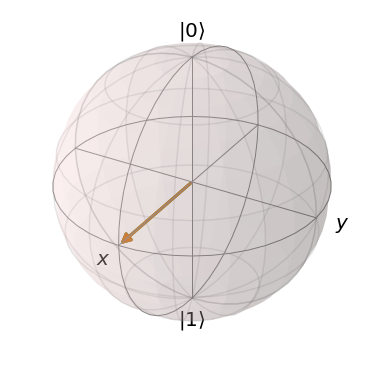

In [ ]:
H_circuit = cirq.Circuit(cirq.H(qubits[0])) # Prepares the |+> state
sim = cirq.DensityMatrixSimulator()

initial_state = sim.simulate(H_circuit).final_density_matrix
noisy_state = sim.simulate(H_circuit.with_noise(bitflip_channel)).final_density_matrix

b = qutip.Bloch()
b.add_vectors(cirq.bloch_vector_from_state_vector(initial_state, 0))
b.add_vectors(cirq.bloch_vector_from_state_vector(noisy_state, 0))
b.show()

No effect at all! The $|+\rangle$ state is not affected by bitflip noise, which turns out to have deep physical connection to the use of stabilizer codes (a type of logical qubit encoding with respect to the Clifford group).

The next example involves "T1" decay. Physically, this describes relaxation of an excited state $|1\rangle$ to a ground state $|0\rangle$.


First 6 layers of noisy circuit:


(0, 0): ───X───AD(0.0333)───I───AD(0.0333)───I───AD(0.0333)───

Text(0, 0.5, "Probability of '1' ")

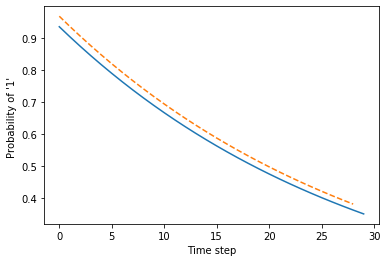

In [ ]:
# Model a qubit with a known T1 value
q = cirq.GridQubit(0, 0)
t1 = 30
n_layers = 30

circuit = cirq.Circuit(cirq.X.on(q)) # excite to |1>
for g in range(n_layers):
  # do nothing.
  circuit += cirq.I(q)

# Noise model will apply T1 style decay for the time n_gates * T(gate)
t1_noise = cirq.amplitude_damp(1 / t1)
noisy_circuit = circuit.with_noise(t1_noise)
print("First 6 layers of noisy circuit:")
display(noisy_circuit[:6])

# Simulate using density matrix simulator; we want to look at the
# excited state probability after each "time step"
sim = cirq.DensityMatrixSimulator()
all_steps = list(sim.simulate_moment_steps(noisy_circuit))
excited_state_probs = []
for step in range(0, len(all_steps), 2):
  final_state = all_steps[step].density_matrix()
  p1 = abs(final_state[1, 1])
  excited_state_probs.append(p1)

# Plot our results
import matplotlib.pyplot as plt
plt.plot(excited_state_probs[:-1])
plt.plot([np.exp(-1*i/t1) for i in range(1, n_layers)], '--')
plt.xlabel("Time step")
plt.ylabel("Probability of '1' ")

So the T1 decay is exponential, with an exponential slope related to the inverse of T1. Importantly, **We see that after ~10 time steps, the states of our qubits might as well be coin flips!** Noise modelling is essential to determining acceptable algorithm depth.

In general, if we want to model qubits in a noisy environment using a quantum circuit simulator then we have to discretize the noise channels and parametrize them using empirical observations. Some other possibilities:
 - T1 decay using `cirq.depolarize`
 - T2 decay using `cirq.dephase`
 - Readout error using `cirq.bitflip`

Some noise effects involve correlations between qubits or time dependence ("Non-Markovian") and cannot be efficiently simulated using the methods above.

### 3. Gate infidelity

Another source of qubit decoherence is gate imperfections, typically called gate "fidelity". Typically this is described by comparing the actual gate applied on the hardware to the idealized perfect gate.

Gate infidelity effects can be simulated on a circuit in a very similar way to qubit decoherence. Analogously to the T1 experiment, if we apply the same gate **n** times we might observe an exponential slope of a given readout related to the gate infidelity times **n**.

### 4. Hardware connectivity

Algorithms must respect a hardware's connectivity. On the Google devices, this means that **only nearest neighbor coupling is allowed**. As a reminder, here's what the Sycamore23 device looks like:

In [ ]:
print(cirq.google.Sycamore23)

                  (3, 2)
                  │
                  │
         (4, 1)───(4, 2)───(4, 3)
         │        │        │
         │        │        │
(5, 0)───(5, 1)───(5, 2)───(5, 3)───(5, 4)
         │        │        │        │
         │        │        │        │
         (6, 1)───(6, 2)───(6, 3)───(6, 4)───(6, 5)
                  │        │        │        │
                  │        │        │        │
                  (7, 2)───(7, 3)───(7, 4)───(7, 5)───(7, 6)
                           │        │        │
                           │        │        │
                           (8, 3)───(8, 4)───(8, 5)
                                    │
                                    │
                                    (9, 4)


Quantum circuit compilers are a type of program designed to fit a given circuit onto a constrained hardware (We'll visit this topic more next lecture). However, its important to recognize that compilation involves a lot of NP problems. Here's an example of a problem you might run into:

```
Compile circuit X to run optimally on hardware respecting the following constraints:
 - cirq sqrt_iswap gateset
 - respect Sycamore23 connectivity
 - two qubit gates on the (7, 4)-(6, 4) pair have 3x lower fidelity
 - qubit (6, 3) has T1 << T1_AVG
 - All remaining T1, T2, and gate fidelity values are: ...
 ```

 This is an open-ended problem and the target of constant research efforts! Never underestimate the difficulty of implementing an algorithm on hardware.

In [ ]:
m = np.array([[1, 1j], [1j, 1]]) * np.sqrt(0.5)
class MyMatrix(cirq.MatrixGate):
  def __init__(self, ...):
    my_unitary = np.array(...)
    self.on()
x2 = cirq.MatrixGate(m)
x2.on(cirq.)

['__abstractmethods__',
 '__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_approx_eq_',
 '_backwards_compatibility_num_qubits',
 '_circuit_diagram_info_',
 '_commutes_',
 '_commutes_on_qids_',
 '_default_shape_from_num_qubits',
 '_from_json_dict_',
 '_has_unitary_',
 '_implemented_by_',
 '_json_dict_',
 '_matrix',
 '_mul_with_qubits',
 '_num_qubits_',
 '_num_qubits_from_shape',
 '_num_qubits_proto_from_num_qubits',
 '_phase_by_',
 '_qid_shape',
 '_qid_shape_',
 '_rmul_with_qubits',
